# Basic BALDER Eiger 1M example data and corrections

Authors: 
- Samuel Selleck
- Zdenek Matej

## Loading data and basic integration

date: Tue, January 4th, 2022

In [1]:
import os, json
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy

## Load data and get mask

In [2]:
rootdir = '/data/staff/common/data/pd'
datafilename = 'LaB6_ref_carmen_data_000001.h5'
filename = os.path.join(rootdir,datafilename)
data_path = '/entry/data/data'
print('%s:%s' % (filename,data_path ,))

/data/staff/common/data/pd/LaB6_ref_carmen_data_000001.h5:/entry/data/data


In [3]:
data = None

with h5py.File(filename,'r') as h5f:
    data = h5f[data_path][()]
    data = np.squeeze(data)
    
print(data.shape)

(1065, 1030)


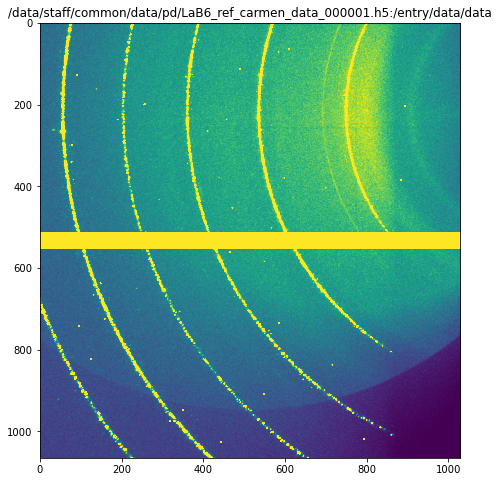

In [4]:
# get estimate of max range ignoring very high values
vmax=np.percentile(data[data<1000000],98)

plt.figure(figsize=(8,8))
plt.imshow(data, vmax=vmax)
plt.title('%s:%s' % (filename,data_path ,));

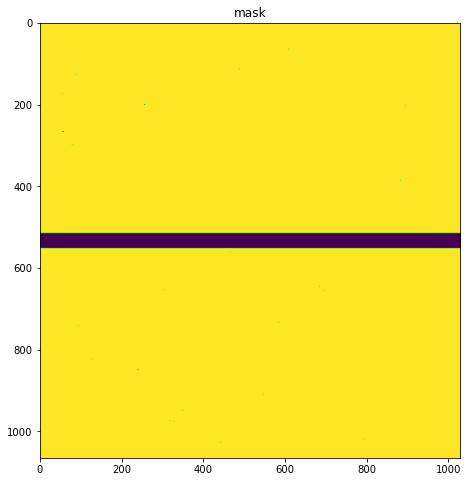

In [5]:
# create mask
# Note: in photon science UINT is often used as data typy,
#       however special values are used to label e.g.
#       -1 ... detector gaps, -2 ... masked hot pixels etc.,
#       moreover there are unmasked hot pixels showing usually
#       very high random values
mask = np.logical_or(data==np.uint32(-1),data==np.uint32(-2))
vmax = np.percentile(data[~mask],99.999)
mask = np.logical_or(mask, data>vmax)

# invert mask
mask = ~mask

img = data.copy()
img[~mask] = 0

plt.figure(figsize=(8,8))
plt.imshow(mask)
plt.title('mask');

## Check calibration parameters

- *Clemens* and *Justus* should have the original calibration file
- this is standrd $LaB_6$ measurement, one can do the calibration yourself, e.g. with *pyFAI* or *Fit2D*
- note: Carmen's *xtrace* code does not include detector tilt yet
- some values were found in Carmen's Python code, in particular: pixelcorrections2Dv1.py (2021, Sep 17)

In [6]:
# pixelcorrections2Dv1.py ... likely some scaled testing values

# pixel dimentions
pl = 75  # pixel length, in micrometers 
pw = 450 # pixel width, in micrometers
ph = 75  # pixel height, in micrometers

# Cartesian coordinates of the sample, given by the poni file 
sx = -0.4051247560395305 * 10**4 # -dist in poni file, in micrometers
sy = 0.17601077769492505 * 10**4 # P2 in poni file, in micrometers
sz = 0.02184240399163788 * 10**4 # P1 in poni file, in micrometers

# in pixel coordinates
sy_pix = sy/pl
sz_pix = sz/ph

In [7]:
# /data/staff/common/data/pd/LaB6_ref_carmen_data_000001_pyFAI_no_tilt.poni
# ... calibration by Zdenek using pyFAI, Jan 4, 2022
#     no tilt, refined energy close to 13 keV

## Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
## Calibration done at Tue Jan  4 17:25:49 2022
#poni_version: 2
#Detector: Eiger1M
#Detector_config: {}
#Distance: 0.15440269217351899
#Poni1: 0.01614699850343882
#Poni2: 0.09233769557958088
#Rot1: 0.0
#Rot2: 0.0
#Rot3: 0.0
#Wavelength: 9.537204867449691e-11

# Cartesian coordinates of the sample, given by the poni file 
sx = -0.15440269217351899 * 10**6 # -dist in poni file, in micrometers
sy =  0.09233769557958088 * 10**6 # P2 in poni file, in micrometers
sz =  0.01614699850343882 * 10**6 # P1 in poni file, in micrometers

wlen = 0.9537204867449691 # Wavelength in Å

# in pixel coordinates
sy_pix = sy/pl
sz_pix = sz/ph

In [8]:
# helper libraries for azimuthal integration geometry from Max-Lab bli711
import maxpy_erda as mp

# note: pyFAI is needed only for poni->Fit2D->bli711 calibration translation
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

deg2rad = np.pi/180.
rad2deg = 180./np.pi

ai = AzimuthalIntegrator() # new integrator
ai.setPyFAI(pixel1=ph*1e-6, pixel2=pl*1e-6,
            dist=0.15440269217351899,
            poni1=0.01614699850343882, poni2=0.09233769557958088,
            rot1=0., rot2=0., rot3=0.,
            splineFile=None)

# convert detector parameters from Carmen's (pyFAI-like) notation to bli711 (Fit2D-like) notation
pf2d = ai.getFit2D()
det_params_b711 = { 'n0': pf2d['centerY'], 'm0': pf2d['centerX'], \
                    'wn': (pf2d['pixelY']*1e-3/pf2d['directDist']), 'wm': (pf2d['pixelX']*1e-3/pf2d['directDist']), \
                    'phi': 0*np.pi/2, \
                    'n': data.shape[0], 'm': data.shape[1], \
                    'rot': pf2d['tiltPlanRotation']*deg2rad , 'tilt': pf2d['tilt']*deg2rad }

print("--- bli711 notation ---")
print(det_params_b711)

# store the bli711 notation in json format
with open(os.path.join(rootdir,'LaB6_notilt.pdet.json'), 'w') as f:
    f.write(json.dumps(det_params_b711))

--- bli711 notation ---
{'n0': 215.2933133791843, 'm0': 1231.1692743944118, 'wn': 0.00048574282575147333, 'wm': 0.00048574282575147333, 'phi': 0.0, 'n': 1065, 'm': 1030, 'rot': 0.0, 'tilt': 0.0}


In [11]:
# here we describe the LaB6 stadard and calculate line positions in 2theta
# for a given wavelenght using the Bragg's law

# we need to know the interplanar distances directly
# or calculate them from reflection indices and the lattice constant

# one could genrate the indices but we can simply read them from a reference ICSD record
# note: 2Theta positios are likely for a different wavelength
# header: H K L 2THETA D-VALUE MULT INTENSITY
icsd_tbl = np.loadtxt(os.path.join(rootdir,'LaB6-icsd.txt'), skiprows=1)
hkl = icsd_tbl[:,0:3].astype(np.int32)
print(hkl)
alat = 4.156468 # Å (tabulated)

# interplanar distances
d_hkl = alat/np.sqrt((hkl**2).sum(axis=1))

# peak positions in 2Theta (Bragg's law)
arg = wlen/2./d_hkl
lidx = arg<=1. # some reflections may be unreachable for our wavelength
d_hkl = d_hkl[lidx]
arg = arg[lidx]
tth_hkl = 2.*np.arcsin(wlen/2./d_hkl)

# we actually see 6 LaB6 lines and so we take only them
# note: some lines still may be there multiple times (in case they overlap)
nhkl = 6
hkl = hkl[:nhkl,:]
d_hkl = d_hkl[:nhkl]
tth_hkl = tth_hkl[:nhkl]

print(tth_hkl*rad2deg)

[[1 0 0]
 [1 1 0]
 [1 1 1]
 [2 0 0]
 [2 1 0]
 [2 1 1]
 [2 2 0]
 [3 0 0]
 [2 2 1]
 [3 1 0]
 [3 1 1]
 [2 2 2]
 [3 2 0]
 [3 2 1]
 [4 0 0]
 [4 1 0]
 [3 2 2]
 [3 3 0]
 [4 1 1]
 [3 3 1]
 [4 2 0]
 [4 2 1]
 [3 3 2]
 [4 2 2]
 [5 0 0]
 [4 3 0]
 [5 1 0]
 [4 3 1]
 [5 1 1]
 [3 3 3]
 [4 3 2]
 [5 2 0]
 [5 2 1]
 [4 4 0]
 [5 2 2]
 [4 4 1]
 [5 3 0]
 [4 3 3]
 [5 3 1]
 [6 0 0]
 [4 4 2]
 [6 1 0]
 [5 3 2]
 [6 1 1]
 [6 2 0]
 [5 4 0]
 [6 2 1]
 [4 4 3]
 [5 4 1]
 [5 3 3]
 [6 2 2]
 [6 3 0]
 [5 4 2]
 [6 3 1]
 [4 4 4]
 [6 3 2]
 [7 0 0]
 [5 5 0]
 [5 4 3]
 [7 1 0]
 [5 5 1]
 [7 1 1]
 [6 4 0]
 [7 2 0]
 [6 4 1]
 [5 5 2]
 [7 2 1]
 [6 3 3]
 [6 4 2]]
[13.17578978 18.67490535 22.92347241 26.5299217  29.72947407 32.64257361]


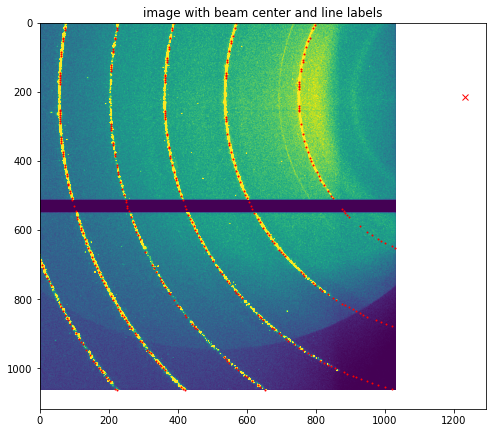

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(img, vmax=np.percentile(img,98))

# plot a cross at a beam center
plt.plot(sy_pix,sz_pix,'rx')

# mark pixels in the image that are on diffraction lines
# note: there is no function 2theta to pixel coords in maxpy_erda as it was not needed for integration

N,M = np.meshgrid(np.linspace(0, det_params_b711['n'], 200), np.linspace(0, det_params_b711['m'], 200))
tth = mp.tth2Dsimple(0.0,N,M,det_params_b711)

dtth = 0.02 * deg2rad
for ihkl in range(nhkl):
    lidx = np.logical_and(tth>=(tth_hkl[ihkl]-dtth), tth<=(tth_hkl[ihkl]+dtth))
    plt.plot(M[lidx],N[lidx],'r.',ms=2)

plt.title('image with beam center and line labels');

If the picture above looks good we have a correct calibration and good understanding of the geometry.

We can just integrate in the next step or correct and integrate.

## Simple integration using numpy bincount

Note: A simple 6 line geometrical function from `maxpy_erda` module is the only exteranl function used here. The modle dependency can be simply dropped. Also `pyFAI` was needed only for conversion between geometry conventions, i.e. can be dropped as well.

In [11]:
tthFnc = mp.tth2Dsimple

In [12]:
# integration grid
print('2theta_max (deg):', np.max(tth)*rad2deg)

# people like nicely spaced data
xtth = np.linspace(0.0, 36*deg2rad, int(36./0.02)+1) # dxtth=0.02 deg

print(xtth*rad2deg)

2theta_max (deg): 36.00338616579098
[0.000e+00 2.000e-02 4.000e-02 ... 3.596e+01 3.598e+01 3.600e+01]


In [13]:
_img = img.copy() # mainly to be sure :-)

### A. No pixel-splitting

Intensity from each pixel is added to a single bin the ideal case of so called *no pixel splitting*.

A single index (*idx*) of each target bin is calculated for each pixel. Some pixels may have no contribution in the given $2\theta$ range. Such pixels have logical index (*lidx*) set to *False*.

In [14]:
_idx, _lidx = mp.ttheq_get_indexes(xtth,delta=0.0,detParams=det_params_b711,N=[],M=[],tthFnc=tthFnc)

print("idx.shape:", _idx.shape)

idx.shape: (1065, 1030)


### bincount

The azimuthal integration, not including corrections, can then be done with numpy *bincount* function.

Logical index (*lidx*) can be used to reduce the number of bincount input data. This is important
only if the integration is required for a reduced $2\theta$ range.

In [15]:
# reduce data (note: creates a copy)
_ridx  = _idx[_lidx]
_rimg  = _img[_lidx]
_rmask = mask[_lidx]
# integrate data
idata_bc = np.bincount(_ridx,weights=_rimg,minlength=len(xtth))
ndata_bc = np.bincount(_ridx,weights=_rmask,minlength=len(xtth))

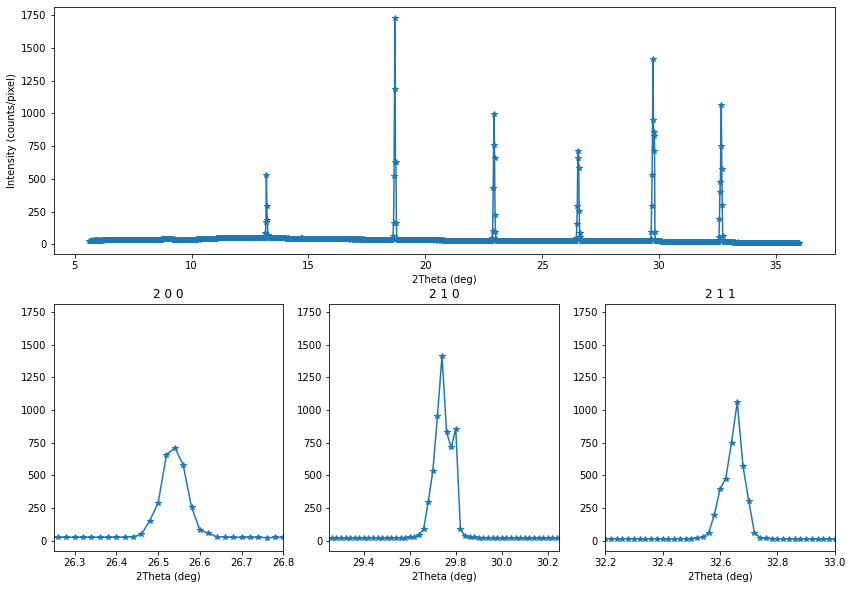

In [16]:
# show integrated data
inorm_bc = np.full_like(xtth,np.nan)
lidx = ndata_bc>0
inorm_bc[lidx] = idata_bc[lidx]/ndata_bc[lidx]
plt.figure(figsize=(14,10))
plt.subplot(2,3,(1,3))
plt.plot(xtth*rad2deg, inorm_bc, "-*")
#plt.xlim((0,5))
plt.xlabel('2Theta (deg)')
plt.ylabel('Intensity (counts/pixel)');
plt.subplot(2,3,4)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((26.25,26.8))
plt.xlabel('2Theta (deg)')
plt.title('2 0 0');
plt.subplot(2,3,5)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((29.25,30.25))
plt.xlabel('2Theta (deg)')
plt.title('2 1 0');
plt.subplot(2,3,6)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((32.2,33.0))
plt.xlabel('2Theta (deg)')
plt.title('2 1 1');

So these are not nice peaks. The issue can be caused by:

- bad callibration, maybe the effect of detector tilt should be included
- we are quite sensitive to distribution of intensity between neighbouring pixels and their geometrical relation to the integration columns, this can be improved (smoothed) by pixel-splitting
- maybe the effect Justus suggested is the main cause of unsymmetrical *ugly* reflections
- it can be also an effect of the sample
  - $LaB_6$ has large defect free grains&crystallites
  - it has also quite some absorption
  - the sample was flat and no rotation neither spin was applyied to increase grain statistics
  - it was not standard transmission detector geometry but the sample was measured in reflection !!!
  - the rings are not continuous but rather a grainy signal is observes, on the other side, there seems to be quite enough hits on each ring

## Corrections

Date: Tue January 11th

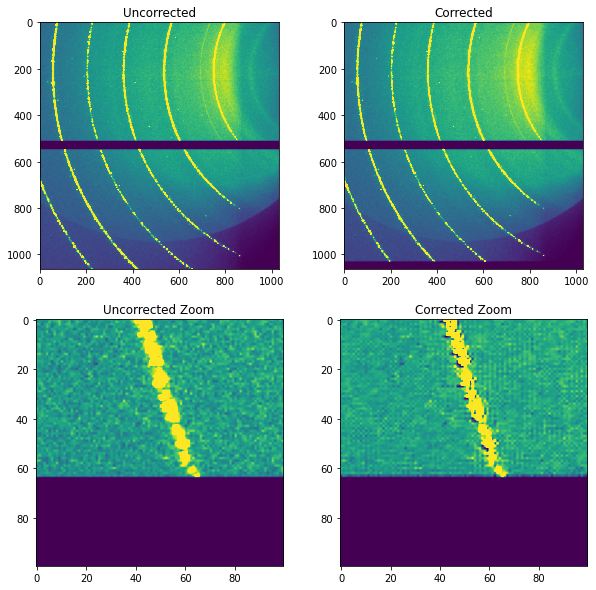

In [17]:
from cupy import meshgrid, linspace
import numpy as np
import cupy as cp
import xtrace
from functools import reduce
import warnings

warnings.simplefilter('error', UserWarning)

plt.rcParams['figure.figsize'] = [10, 10]
det_numpixels = img.shape
###############################################################################
#information of the frontal intersection point
#hit_col, hit_row and j should be given
hit_col, hit_row = meshgrid(linspace(0, det_numpixels[0], det_numpixels[0]), linspace(0, det_numpixels[1], det_numpixels[1])) # for 100 rays
#hit_col, hit_row = meshgrid(linspace(0.5, 100-0.5, 2*1000), linspace(0.5, 100-0.5, 2*1000)) # for 1M rays
hit_row = hit_row.flatten()
hit_col = hit_col.flatten()

#To mention:

det_params = {
    "mu": 3.445930 * 10**-3, #in 1/micron
    "IO": 1,
    #pixel dimentions
    "pl": pl,
    "pw": pw,
    "ph": ph,
    #detector dimentions
    "det_numpixels": det_numpixels, #number of rows in pixels, number of columns in pixels
    #detector limits in Cartesian coordinates
    "det_xlim": (0.0, pw),
    "det_ylim": (0.0, det_numpixels[1] * pl),
    "det_zlim": (0.0, det_numpixels[0] * ph),
    #Cartesian coordinates of the sample, given by the poni file 
    "sx": sx, # -dist in poni file, in micrometers
    "sy": sy, # P2 in poni file, in micrometers
    "sz": sz, # P1 in poni file, in micrometers

    #for the construction of the plane
    "Jj": 10, # positive or negative integer number related to the plane point
    #positive means either to the right or upwards
    #negative means either to the left or downwards
    #planevec
    #"planevec": np.array([[0,1,0]]), #OBS Unused
}


def regularized_richard_lucy_deconv(img, psf, smooth_coeff, iters):
    np = cp
    pixel_arr = np.array(img).reshape(-1)
    pixel_arr_itr = pixel_arr.copy()
    for _ in range(iters):
        c = psf@pixel_arr_itr
        c[c == 0] = 1
        grad = np.array(np.gradient(pixel_arr_itr.reshape(img.shape)))
        norms = np.sum(np.abs(grad),axis=0)
        norms[norms == 0] = 1
        grad /=norms
        divergence = np.gradient(grad[0],axis=0) + np.gradient(grad[1], axis=1)
        divergence_arr = divergence.reshape(-1)
        sm = psf.T@(pixel_arr/c)
        pixel_arr_itr = pixel_arr_itr*sm/(1 - smooth_coeff*divergence_arr) 
    return pixel_arr_itr.reshape(img.shape)


G = xtrace.sensor_depth_spill_psf(det_params, hit_row, hit_col)

perc = np.percentile(img, 98)
recovered_img = regularized_richard_lucy_deconv(img, G, 0.08, 100).get()
r_perc = np.percentile(recovered_img, 98)
#r_n_perc = np.percentile(recov_no_reg, 100)
area = (slice(450,550), slice(350,450))
fig, axs = plt.subplots(2, 2)
axs[0, 0].set_title("Uncorrected")
axs[0, 0].imshow(img, vmax=perc)
axs[0, 1].set_title("Corrected")
axs[0, 1].imshow(recovered_img, vmax=r_perc) # r_n_perc
axs[1, 0].set_title("Uncorrected Zoom")
axs[1, 0].imshow(img[area], vmax=perc)
axs[1, 1].set_title("Corrected Zoom")
axs[1, 1].imshow(recovered_img[area], vmax=r_perc)
plt.show()

### bincount on recovered image

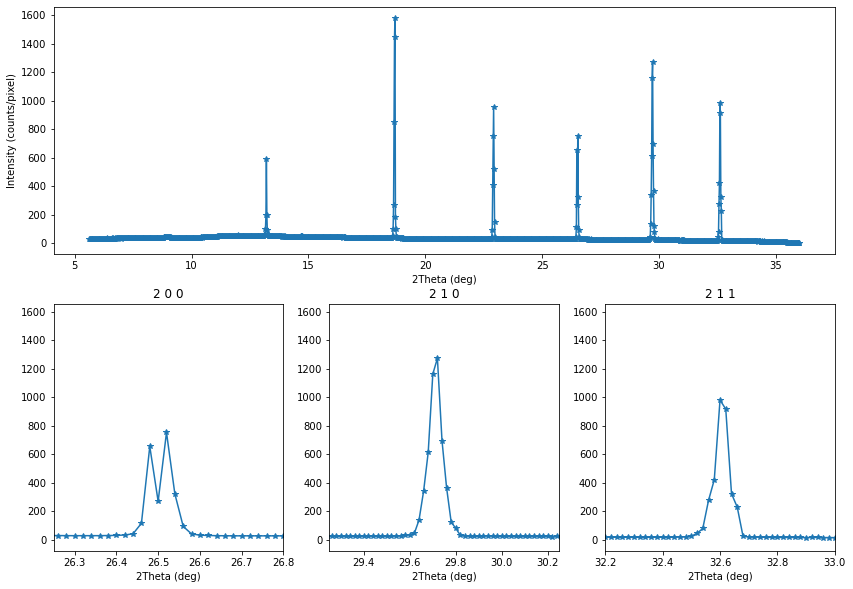

In [18]:
_img = recovered_img.copy() # mainly to be sure :-)

# reduce data (note: creates a copy)
_ridx  = _idx[_lidx]
_rimg  = _img[_lidx]
_rmask = mask[_lidx]

# integrate data
idata_bc = np.bincount(_ridx,weights=_rimg,minlength=len(xtth))
ndata_bc = np.bincount(_ridx,weights=_rmask,minlength=len(xtth))

# show integrated data
inorm_bc = np.full_like(xtth,np.nan)
lidx = ndata_bc>0
inorm_bc[lidx] = idata_bc[lidx]/ndata_bc[lidx]
plt.figure(figsize=(14,10))
plt.subplot(2,3,(1,3))
plt.plot(xtth*rad2deg, inorm_bc, "-*")
#plt.xlim((0,5))
plt.xlabel('2Theta (deg)')
plt.ylabel('Intensity (counts/pixel)');
plt.subplot(2,3,4)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((26.25,26.8))
plt.xlabel('2Theta (deg)')
plt.title('2 0 0');
plt.subplot(2,3,5)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((29.25,30.25))
plt.xlabel('2Theta (deg)')
plt.title('2 1 0');
plt.subplot(2,3,6)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((32.2,33.0))
plt.xlabel('2Theta (deg)')
plt.title('2 1 1');

- 211 is good but 210 looks ugly now

## bincount with pixel splitting

In [19]:
_idx_split, _wgt_split = \
    mp.ttheq_get_indexes_withPixelSplitting(xtth, delta=0.0,
                                            detParams=det_params_b711,
                                            N=[],M=[],
                                            tthFnc=tthFnc)

print("maximum pixel split-width: %d" % (_idx_split.shape[-1],))
print("maximum pixel split: %d" % (np.max(np.sum((_wgt_split>0).astype('uint8'),axis=-1)),))

_nbvpix = np.sum((_wgt_split>0).astype('uint32'))
print("nb virtual pixels: %d/%d = %.3f" % (_nbvpix, np.prod(_idx_split.shape[:-1]), _nbvpix/np.prod(_idx_split.shape[:-1])))

# for compatibility with FPGA
fptp = np.dtype(np.float32)
_idx_split = _idx_split.astype(np.int16)
_wgt_split = _wgt_split.astype(fptp)

print("\nExample: 4 pixels in the corner:\n\n", _idx_split[:2,:2,:], "\n\n", _wgt_split[:2,:2,:])

maximum pixel split-width: 3
maximum pixel split: 3
nb virtual pixels: 3187880/1096950 = 2.906

Example: 4 pixels in the corner:

 [[[1563 1564 1565]
  [1562 1563 1564]]

 [[1562 1563 1564]
  [1561 1562 1563]]] 

 [[[0.00831748 0.98336506 0.00831748]
  [0.00852601 0.982948   0.00852601]]

 [[0.00835411 0.9832918  0.00835411]
  [0.00856264 0.9828747  0.00856264]]]


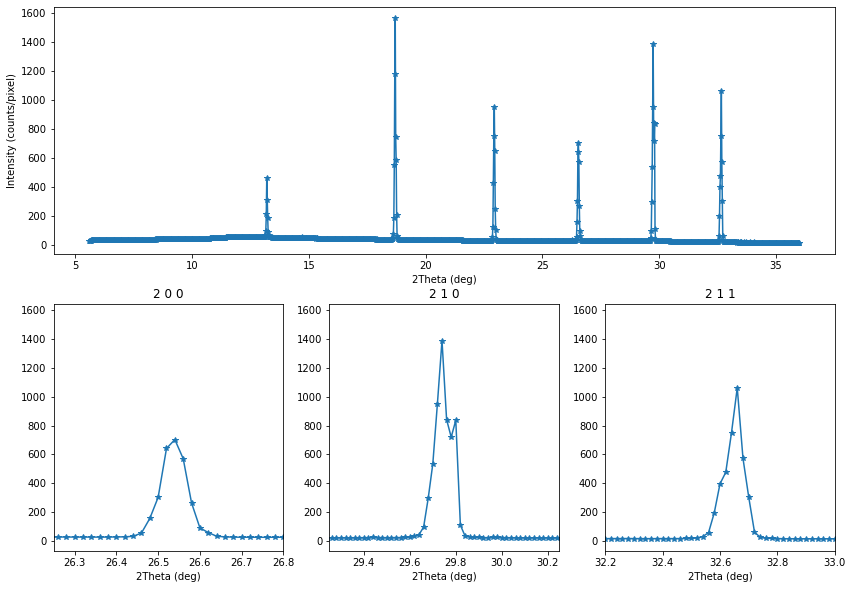

In [20]:
_img = img.copy() # mainly to be sure :-)

idata_bc = np.zeros(xtth.shape, dtype=fptp)
ndata_bc = np.zeros(xtth.shape, dtype=fptp)

for k in range(_idx_split.shape[-1]):
   # reduce data
   _lidx  = _wgt_split[:,:,k]>0.
   _ridx  = _idx_split[_lidx,k]
   _rimg  = _img[_lidx]*_wgt_split[_lidx,k]
   _rmask = mask[_lidx]*_wgt_split[_lidx,k]
   # integrate data
   idata_bc += np.bincount(_ridx,weights=_rimg,minlength=len(xtth))
   ndata_bc += np.bincount(_ridx,weights=_rmask,minlength=len(xtth))
    
# show integrated data
inorm_bc = np.full_like(xtth,np.nan)
lidx = ndata_bc>0
inorm_bc[lidx] = idata_bc[lidx]/ndata_bc[lidx]
plt.figure(figsize=(14,10))
plt.subplot(2,3,(1,3))
plt.plot(xtth*rad2deg, inorm_bc, "-*")
#plt.xlim((0,5))
plt.xlabel('2Theta (deg)')
plt.ylabel('Intensity (counts/pixel)');
plt.subplot(2,3,4)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((26.25,26.8))
plt.xlabel('2Theta (deg)')
plt.title('2 0 0');
plt.subplot(2,3,5)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((29.25,30.25))
plt.xlabel('2Theta (deg)')
plt.title('2 1 0');
plt.subplot(2,3,6)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((32.2,33.0))
plt.xlabel('2Theta (deg)')
plt.title('2 1 1');

It seems pixel-splitting will not help in this case.

### Corrections and pixel splitting

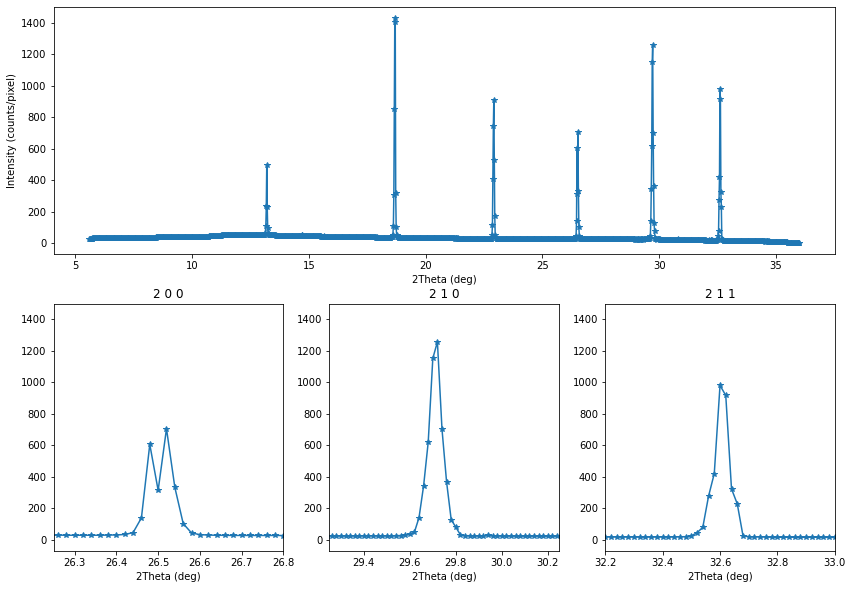

In [21]:
_img = recovered_img.copy() # mainly to be sure :-)

idata_bc = np.zeros(xtth.shape, dtype=fptp)
ndata_bc = np.zeros(xtth.shape, dtype=fptp)

for k in range(_idx_split.shape[-1]):
   # reduce data
   _lidx  = _wgt_split[:,:,k]>0.
   _ridx  = _idx_split[_lidx,k]
   _rimg  = _img[_lidx]*_wgt_split[_lidx,k]
   _rmask = mask[_lidx]*_wgt_split[_lidx,k]
   # integrate data
   idata_bc += np.bincount(_ridx,weights=_rimg,minlength=len(xtth))
   ndata_bc += np.bincount(_ridx,weights=_rmask,minlength=len(xtth))
    
# show integrated data
inorm_bc = np.full_like(xtth,np.nan)
lidx = ndata_bc>0
inorm_bc[lidx] = idata_bc[lidx]/ndata_bc[lidx]
plt.figure(figsize=(14,10))
plt.subplot(2,3,(1,3))
plt.plot(xtth*rad2deg, inorm_bc, "-*")
#plt.xlim((0,5))
plt.xlabel('2Theta (deg)')
plt.ylabel('Intensity (counts/pixel)');
plt.subplot(2,3,4)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((26.25,26.8))
plt.xlabel('2Theta (deg)')
plt.title('2 0 0');
plt.subplot(2,3,5)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((29.25,30.25))
plt.xlabel('2Theta (deg)')
plt.title('2 1 0');
plt.subplot(2,3,6)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((32.2,33.0))
plt.xlabel('2Theta (deg)')
plt.title('2 1 1');

No improvement. One should try to add detector tilt into the calibration.

In [22]:
# /data/staff/common/data/pd/LaB6_ref_carmen_data_000001_pyFAI_with_tilt.poni
# ... calibration by Zdenek using pyFAI, Jan 18, 2022
#     with tilt, refined energy close to 13 keV, left the same value as without tilt

## Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
## Calibration done at Tue Jan 18 02:00:52 2022
#poni_version: 2
#Detector: Eiger1M
#Detector_config: {}
#Distance: 0.15489975350657686
#Poni1: 0.01614278607066403
#Poni2: 0.09180410102094835
#Rot1: -0.0040493046824370575
#Rot2: -0.0002806766285723626
#Rot3: 0.0
#Wavelength: 9.537204867449691e-11
    
ai.setPyFAI(pixel1=ph*1e-6, pixel2=pl*1e-6,
            dist=0.15489975350657686,
            poni1=0.01614278607066403, poni2=0.09180410102094835,
            rot1=-0.0040493046824370575, rot2=-0.0002806766285723626, rot3=0.,
            splineFile=None)

# convert detector parameters from Carmen's (pyFAI-like) notation to bli711 (Fit2D-like) notation
pf2d = ai.getFit2D()

In [23]:
# convert detector parameters from Carmen's (pyFAI-like) notation to bli711 (Fit2D-like) notation
pf2d = ai.getFit2D()
det_params_b711_tilt = { 'n0': pf2d['centerY'], 'm0': pf2d['centerX'], \
                    'wn': (pf2d['pixelY']*1e-3/pf2d['directDist']), 'wm': (pf2d['pixelX']*1e-3/pf2d['directDist']), \
                    'phi': 0*np.pi/2, \
                    'n': data.shape[0], 'm': data.shape[1], \
                    'rot': pf2d['tiltPlanRotation']*deg2rad , 'tilt': pf2d['tilt']*deg2rad }

print("--- bli711 notation ---")
print(det_params_b711_tilt)

# store the bli711 notation in json format
with open(os.path.join(rootdir,'LaB6_tilt.pdet.json'), 'w') as f:
    f.write(json.dumps(det_params_b711_tilt))

--- bli711 notation ---
{'n0': 214.6574529666371, 'm0': 1232.4178766185385, 'wn': 0.0004841801259605506, 'wm': 0.0004841801259605506, 'phi': 0.0, 'n': 1065, 'm': 1030, 'rot': -0.06920427216933765, 'tilt': 0.004059020491498709}


In [24]:
tthFnc_tilt = mp.tth2DwithTilt

In [25]:
_idx_split, _wgt_split = \
    mp.ttheq_get_indexes_withPixelSplitting(xtth, delta=0.0,
                                            detParams=det_params_b711_tilt,
                                            N=[],M=[],
                                            tthFnc=tthFnc_tilt)

print("maximum pixel split-width: %d" % (_idx_split.shape[-1],))
print("maximum pixel split: %d" % (np.max(np.sum((_wgt_split>0).astype('uint8'),axis=-1)),))

_nbvpix = np.sum((_wgt_split>0).astype('uint32'))
print("nb virtual pixels: %d/%d = %.3f" % (_nbvpix, np.prod(_idx_split.shape[:-1]), _nbvpix/np.prod(_idx_split.shape[:-1])))

# for compatibility with FPGA
fptp = np.dtype(np.float32)
_idx_split = _idx_split.astype(np.int16)
_wgt_split = _wgt_split.astype(fptp)

maximum pixel split-width: 3
maximum pixel split: 3
nb virtual pixels: 3190980/1096950 = 2.909


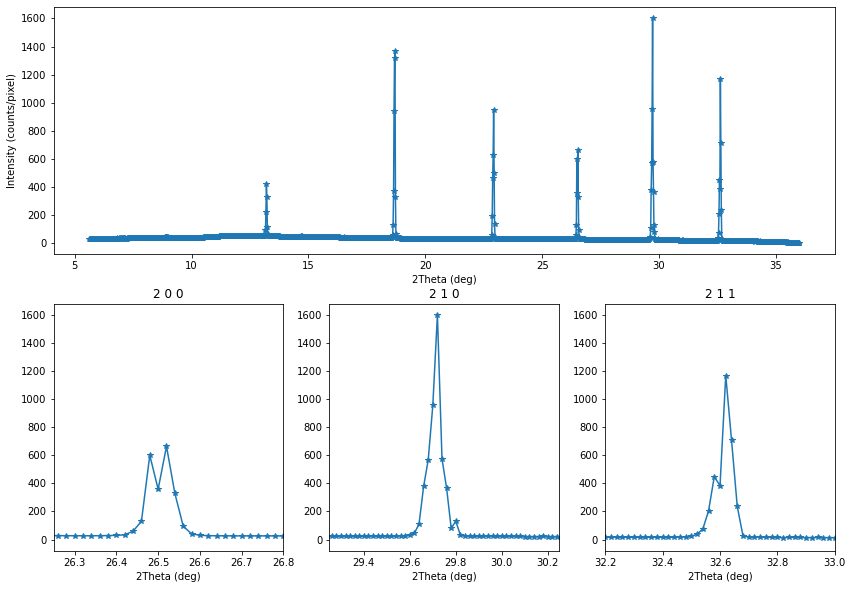

In [26]:
# use 'img' or 'recovered_img' here
_img = recovered_img.copy() # mainly to be sure :-)
#_img = img.copy() # mainly to be sure :-)

idata_bc = np.zeros(xtth.shape, dtype=fptp)
ndata_bc = np.zeros(xtth.shape, dtype=fptp)

for k in range(_idx_split.shape[-1]):
   # reduce data
   _lidx  = _wgt_split[:,:,k]>0.
   _ridx  = _idx_split[_lidx,k]
   _rimg  = _img[_lidx]*_wgt_split[_lidx,k]
   _rmask = mask[_lidx]*_wgt_split[_lidx,k]
   # integrate data
   idata_bc += np.bincount(_ridx,weights=_rimg,minlength=len(xtth))
   ndata_bc += np.bincount(_ridx,weights=_rmask,minlength=len(xtth))
    
# show integrated data
inorm_bc = np.full_like(xtth,np.nan)
lidx = ndata_bc>0
inorm_bc[lidx] = idata_bc[lidx]/ndata_bc[lidx]
plt.figure(figsize=(14,10))
plt.subplot(2,3,(1,3))
plt.plot(xtth*rad2deg, inorm_bc, "-*")
#plt.xlim((0,5))
plt.xlabel('2Theta (deg)')
plt.ylabel('Intensity (counts/pixel)');
plt.subplot(2,3,4)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((26.25,26.8))
plt.xlabel('2Theta (deg)')
plt.title('2 0 0');
plt.subplot(2,3,5)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((29.25,30.25))
plt.xlabel('2Theta (deg)')
plt.title('2 1 0');
plt.subplot(2,3,6)
plt.plot(xtth*rad2deg, inorm_bc, "-*")
plt.xlim((32.2,33.0))
plt.xlabel('2Theta (deg)')
plt.title('2 1 1');

- Detector tilt did not help much, it is maybe even worse
- Try to play with `xtth` step, oversample data a lot with $\Delta tth=0.01^\circ$ or opposite try a larger value $\Delta tth=0.03^\circ$. It can be adjusted in the cell #12

In [127]:
# model functions for diffraction line fitting
# ack: Gudrun Lotze

def gaussian(x,p):
    y = np.log(2.) * ( (x - p[1])/(0.5*p[2]) )**2
    y = p[0]*np.exp(-y)
    y =  y * 2.*np.sqrt(np.log(2.)/np.pi)/p[2]
    return y

def lorentzian(x,p):
    y = (x - p[1])/(0.5*p[2])
    y = p[0]/(1.+y**2)
    y =  y * 2./np.pi/p[2]
    return y

# (multi-peak) pseudoVoigt function
# parameters = [integI, position, fwhm, LorentzianContent]
# one raw of output matrix per parameters line (one peak in each raw)
# you can sum them by numpy.sum(pseudoVoigt(x,p),0)
def pseudoVoigt(x,p):
    a = np.array(p)
    m = a.size // 4
    a = a.reshape(m,4)
    y = np.zeros((m,len(x)),dtype=np.float32)
    for k in range(0,m):
        if np.absolute(a[k,0])>0.:
            y[k] = (1.-a[k,3])*gaussian(x,a[k,0:3])+a[k,3]*lorentzian(x,a[k,0:3])
    return y

# (multi-peak) pseudoVoigtAsym function
# parameters = [integI, position, fwhm, LorentzianContent, Asymmetry]
# one raw of output matrix per parameters line (one peak in each raw)
# you can sum them by numpy.sum(pseudoVoigtAsym(x,p),0)
def pseudoVoigtAsym(x,p):
    a = np.array(p)
    m = a.size // 5
    a = a.reshape(m,5)
    y = np.zeros((m,len(x)),dtype=np.float32)
    for k in range(0,m):
        if np.absolute(a[k,0])>0.:
            s1 = (1. +    a[k,4])*a[k,2]/2
            s2 = (1. + 1./a[k,4])*a[k,2]/2
            ss = (s1 + s2)/2
            lidx = x < a[k,1]
            y[k, lidx]  = (1.-a[k,3])*s1/ss*gaussian(x[lidx],a[k,0:2].tolist()+[s1])
            y[k, lidx] +=     a[k,3] *s1/ss*lorentzian(x[lidx],a[k,0:2].tolist()+[s1,])
            y[k,~lidx]  = (1.-a[k,3])*s2/ss*gaussian(x[~lidx],a[k,0:2].tolist()+[s2])
            y[k,~lidx] +=     a[k,3] *s2/ss*lorentzian(x[~lidx],a[k,0:2].tolist()+[s2,])
    return y

# model - multiple pseudovoigt with linear background
def model1(x,*p):
    y = np.sum(pseudoVoigt(x,p[0:-2]),0)
    y = y + p[-2]*(x-x[0]) + p[-1]
    return y

# model - multiple pseudoVoigtAsym with linear background
def model1a(x,*p):
    y = np.sum(pseudoVoigtAsym(x,p[0:-2]),0)
    y = y + p[-2]*(x-x[0]) + p[-1]
    return y

i0: 60.4, pos: 32.6231 (deg), fwhm: 0.0504 (deg), k: 0.25, asym: 1.07


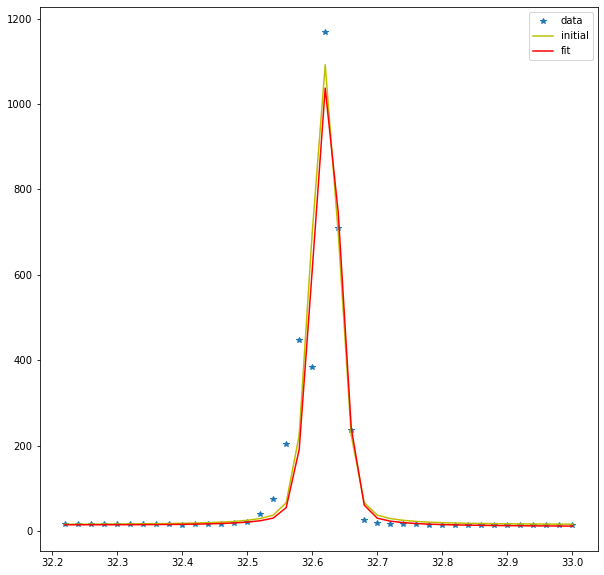

In [151]:
# select peak data
plidx = np.logical_and(xtth>=32.2*deg2rad,xtth<=33.0*deg2rad)
xx = xtth[plidx]
yy = inorm_bc[plidx]
plt.plot(xx*rad2deg, yy,'*',label='data')

# estimate parameters
bkg0 = np.mean( np.concatenate((yy[0:3],yy[-4:-1])) ) # estimate background
# data maximum
i0 = np.argmax(yy); x0 = xx[i0]; y0 = yy[i0]-bkg0
yi = np.trapz(yy-bkg0,xx)
# fwhm (fixed)
fwhm0 = 0.05 # (deg)
# asymmetry
asym0 = 1.0
# model parameters
p0 = [yi, x0, fwhm0*deg2rad, 0.3, asym0, 0.0, bkg0] # [intensity,pos,fwhm,shape,asym,slope,intercept]
# initial model
yyc = model1a(xx,*p0)
plt.plot(xx*rad2deg, yyc,'y-',label='initial')
# fitting
model = model1a
p1, pcov = scipy.optimize.curve_fit(model,xx,yy,p0,sigma=np.sqrt(yy),absolute_sigma=True)
#p1, pcov = scipy.optimize.curve_fit(model,xx,yy,p0)
perr = np.sqrt(np.diag(pcov))
# check shape parameter
if np.any(p1[3::5]<0.) or np.any(p1[3::5]>1.):
    print('warning: invalid shape parameter')
yyc = model(xx,*p1)
plt.plot(xx*rad2deg, yyc,'r-',label='fit')
plt.legend();
print('i0: %.1f, pos: %.4f (deg), fwhm: %.4f (deg), k: %.2f, asym: %.2f' % 
     (p1[0]*rad2deg,p1[1]*rad2deg,p1[2]*rad2deg,p1[3],p1[4],))

- `scipy.optimize.curve_fit` seems to prefer to stay close to initial guess !!!